In [2]:
import numpy as np
import lalsimulation as lalsim
import lal
import matplotlib.pyplot as plt
import pycbc.conversions as cv
import pycbc.waveform
import pycbc.psd
import lalsimulation as lalsim
import emcee
import corner
import multiprocessing as mp
import matplotlib.patches as mpatches
from multiprocessing import Pool

np.random.seed(12345)
%matplotlib inline
%env LAL_DATA_PATH=/work/lprudenzi/opt/lalsuite-extra/data/lalsimulation

env: LAL_DATA_PATH=/work/lprudenzi/opt/lalsuite-extra/data/lalsimulation


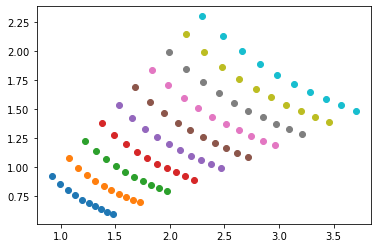

In [3]:
# PRIOR
q_low = 1  
q_high = 2
Mc_low = 1
Mc_high = 2.5
lambda_low = 0
lambda_high = 3000

Mc_arr = np.linspace(0.8,2,10)
q_arr = np.linspace(1,2.5,10)
for q in q_arr:
    for Mc in Mc_arr:
        m1 = cv.mass1_from_mchirp_q(Mc,q)
        m2 = cv.mass2_from_mchirp_q(Mc,q)
        plt.scatter(m1,m2)
plt.show()

def lprior_q(q):
    if q < q_low or q > q_high:
        return -1e10 
    else:
        return np.log(1/(q_high - q_low))

def lprior_Mc(Mc):
    
    if Mc < Mc_low or Mc > Mc_high:
        return -1e10
    else:
        return np.log(1/(Mc_high - Mc_low))

def lprior_lambda(lambda_):
    
    if lambda_ < lambda_low or lambda_ > lambda_high:
        return -1e10
    else:
        return np.log(1/(lambda_high - lambda_low))

In [10]:
def lambda1_lambda2_from_lambda_tilde(m1,m2):
    # Conversion lambda_tilde -> lambda1, lambda2
    # assuming lambda1 * m1**5 = lambda2 * m2**5.
    # See, e.g., Wade et al., https://arxiv.org/pdf/1402.5156.pdf.
    eta = cv.eta_from_mass1_mass2(m1_inj, m2_inj)
    q = m2_inj / m1_inj
    lambda1 = 13 / 8 * lambda_tilde_inj / (
        (1 + 7 * eta - 31 * eta**2) * (1 + q**-5) +
        (1 - 4 * eta)**0.5 * (1 + 9 * eta - 11 * eta**2) * (1 - q**-5))
    lambda2 = lambda1_inj / q**5
    return lambda1, lambda2

# INJECTED PARAMETERS
approx_fd = "SEOBNRv4T_Surrogate"
m1_inj = 1.4
m2_inj = 1.3
Mc_inj = cv.mchirp_from_mass1_mass2(m1_inj,m2_inj)
q_inj = cv.q_from_mass1_mass2(m1_inj,m2_inj)
lambda_tilde_inj = 400
lambda1_inj, lambda2_inj = lambda1_lambda2_from_lambda_tilde(m1_inj, m2_inj)
print("Inj parameters: ", Mc_inj, q_inj, lambda1_inj, lambda2_inj)

distance = 100 * 1e6 * lal.PC_SI
f_lower = 30
f_upper = 2048


Mc_SI = Mc_inj*lal.MSUN_SI
T = 5/256./(np.pi*f_lower)**(8/3.)*(lal.C_SI**3/(lal.G_SI*Mc_SI))**(5./3)
df = 0.01

print(1/T)


0.01755330857595882
1.1742757165047846 1.0769230769230769 332.65090630164497 481.8502935169146


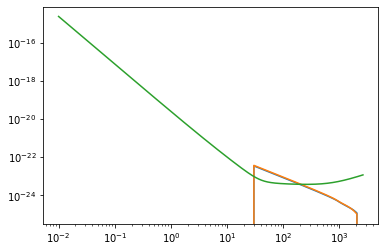

In [12]:
# INJECTED WAVEFORM 
def htilde(par, approx_fd="SEOBNRv4T_Surrogate"):
    Mc = par[0]
    q = par[1]
    lambda_tilde = par[3]
    
    m1 = cv.mass1_from_mchirp_q(Mc,q)
    m2 = cv.mass2_from_mchirp_q(Mc,q)
    lambda1, lambda2 = lambda1_lambda2_from_lambda_tilde(m1, m2)

    params_lal = lal.CreateDict()
    lalsim.SimInspiralWaveformParamsInsertTidalLambda1(params_lal, lambda1)
    lalsim.SimInspiralWaveformParamsInsertTidalLambda2(params_lal, lambda2)
    approx_lal = lalsim.GetApproximantFromString(approx_fd)
            
    hp_fd, hc_fd = lalsim.SimInspiralChooseFDWaveform(
                    m1*lal.MSUN_SI,
                    m2*lal.MSUN_SI,
                    0,
                    0, 
                    s1z,
                    0,
                    0,
                    s2z,
                    distance,
                    0,
                    0,
                    0,
                    0,
                    0,
                    df,
                    f_lower,
                    f_upper,
                    f_lower,
                    params_lal,
                    approx_lal)
            
    freq = np.arange(hp_fd.data.length)*df

    hp_fd = hp_fd.data.data
    hc_fd = hc_fd.data.data
    h = hp_fd+1j*hc_fd

    return freq, h


freq, h_inj = htilde([Mc_inj,q_inj,lambda1_inj, lambda2_inj])
psd = []

for f in freq:
    psd.append(lalsim.SimNoisePSDaLIGOZeroDetHighPower(f))

asd = np.sqrt(psd)
plt.loglog(freq, np.abs(h_inj))
plt.loglog(freq, np.abs(h_2))
plt.loglog(freq, asd)
plt.show()

In [13]:
def inner_prod(h1_f,h2_f,psd):
    return (4*df) * np.real(np.nansum(np.conjugate(h1_f)*h2_f/psd))


snr2 = inner_prod(h_inj,h_inj,psd)
rho = np.sqrt(snr2)
print('Optimal SNR for the resolved source is',rho)

Optimal SNR for the resolved source is 63.635796431054594


<ipython-input-13-f8b4c902e753>:2: RuntimeWarning: invalid value encountered in true_divide
  return (4*df) * np.real(np.nansum(np.conjugate(h1_f)*h2_f/psd))


In [15]:
def llike(params):
    " Log likelihood with correction term that is numerically marginalized "

    # deltah_sampled = gpr_model.predict(params)
    # f, h_sampled = htilde(params)+deltah_sampled
    f, h_sampled = htilde(params)
    return(-0.5 * np.nansum((np.abs(h_inj - h_sampled)**2) / psd))

def lpost(params):
    " Log posterior"
    Mc = params[0]
    q = params[1]
    lambda_tilde = params[2]

    if Mc < Mc_low or Mc > Mc_high or q < q_low or q > q_high or lambda_tilde < lambda_low or lambda_tilde > lambda_high:
        res = -np.inf
    else:
        res = llike(params) + lprior_Mc(Mc) + lprior_q(q)+lprior_lambda(lambda1)+lprior_lambda(lambda2)
    return res

In [16]:
iterations = 10000
nwalkers = 16

injection_params = [Mc_inj,q_inj,lambda1_inj, lambda2_inj]
start = pos*(1+1e-2* np.random.randn(nwalkers, 4))
pool= Pool(32)

nwalkers, ndim = start.shape
sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost, pool=pool)
sampler.run_mcmc(start, iterations, progress=True)

100%|██████████| 10000/10000 [29:14<00:00,  5.70it/s]


State([[1.00036948e+00 1.33829411e+00 2.87945745e+03 4.99157775e+03]
 [1.17426282e+00 1.11357809e+00 5.59551637e+02 1.71301029e+02]
 [1.17428252e+00 1.05324967e+00 6.18508628e+02 1.95243712e+02]
 [1.00030527e+00 1.97590404e+00 8.53550885e+02 8.24281374e+00]
 [1.17427779e+00 1.07467799e+00 5.13912418e+02 3.36580338e+02]
 [1.17427287e+00 1.08401687e+00 1.90850584e+02 7.42763900e+02]
 [1.17427539e+00 1.07968322e+00 5.65143079e+02 2.40251326e+02]
 [1.17427530e+00 1.08042189e+00 4.79574866e+02 3.86510884e+02]
 [1.17427722e+00 1.07147911e+00 3.29787954e+02 5.86573516e+02]
 [1.00037566e+00 1.34358636e+00 2.86137946e+03 4.95633649e+03]
 [1.17427351e+00 1.08529870e+00 1.53495128e+02 7.80032133e+02]
 [1.17427488e+00 1.07936615e+00 2.49002111e+02 6.76054161e+02]
 [1.17427728e+00 1.07939659e+00 5.65882678e+02 2.31054184e+02]
 [1.17427372e+00 1.08366568e+00 2.40299654e+02 6.86566861e+02]
 [1.00030782e+00 1.97478350e+00 8.53683394e+02 1.71715609e+01]
 [1.00037225e+00 1.33780294e+00 2.88051190e+03 4.

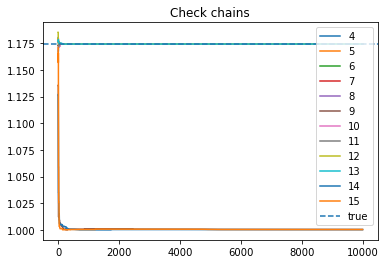

Gelman-Rubin statistic 547.3603581932063  for variable  0


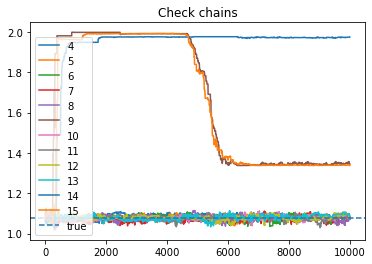

Gelman-Rubin statistic 3.21309604475975  for variable  1


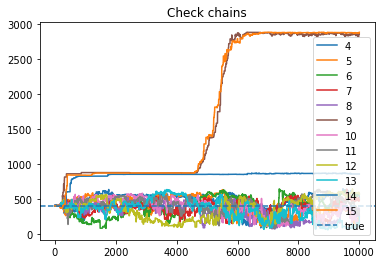

Gelman-Rubin statistic 1.7675267426879249  for variable  2


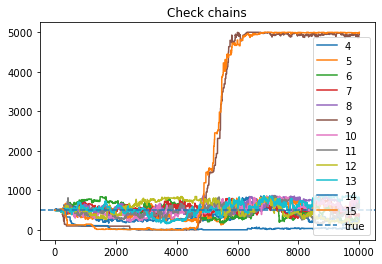

Gelman-Rubin statistic 1.347127841574186  for variable  3


In [23]:
burnin = 1000
chains = sampler.get_chain(discard=0, thin=1, flat=False)
for variable in range(4):
    plt.figure()
    plt.title('Check chains')
    for i in range(4, nwalkers):
        plt.plot(chains[:,i,variable], label=str(i))

    plt.axhline(pos[variable] ,label='true',linestyle='--')
    plt.legend()
    plt.show()

    # Gelman-Rubin statistic
    N = len(chains[burnin:,i,variable])
    W = 1/nwalkers * np.sum([ np.var(chains[burnin:,j,variable]) for j in range(1, nwalkers)])
    theta_bar_bar = np.mean([ np.mean(chains[burnin:,j,variable]) for j in range(1, nwalkers)])
    B = N/(nwalkers-1) *  np.sum([(np.mean(chains[burnin:,j,variable]) - theta_bar_bar)**2 for j in range(1, nwalkers)])
    Var = (1-1/N)*W + B/N
    R = np.sqrt(Var/W)
    print('Gelman-Rubin statistic', R, ' for variable ', variable)

In [26]:
org_samp = np.vstack( (chains[:,:,0].flatten(), #mass samples.
                       chains[:,:,1].flatten(), #mass-ratios
                       chains[:,:,2].flatten(),
                       chains[:,:,3].flatten() #spin samples.
                      ) ).T
print("number of samples = ", np.shape(org_samp))
print("median = ", np.median(org_samp,axis=0))
print("inj = ", Mc_inj, q_inj, lambda1_inj, lambda2_inj)

number of samples =  (160000, 4)
median =  [  1.17427268   1.08442804 482.60588985 468.6911541 ]
inj =  1.1742757165047846 1.0769230769230769 400 500


In [27]:
CORNER_KWARGS = dict(
    smooth=0.99, # smooths out contours. 
    plot_datapoints=False, # choose if you want datapoints
    label_kwargs=dict(fontsize=12.5), # font size for labels
    show_titles=True, #choose if you want titles on top of densities.
    title_kwargs=dict(fontsize=12.5), # font size for title
    plot_density=False,
    quantiles=[0.16, 0.84],  # add quantiles to plot densities. 
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.)),
    fill_contours=True, #decide if you want to fill the contours
    max_n_ticks=1, # set a limit to ticks in the x-y axes.
    title_fmt=".1e", # format for high powers (here 10^2 ~ e+02 etc.)
    reverse=False  # if you are a madman, reverse the whole contour.
)

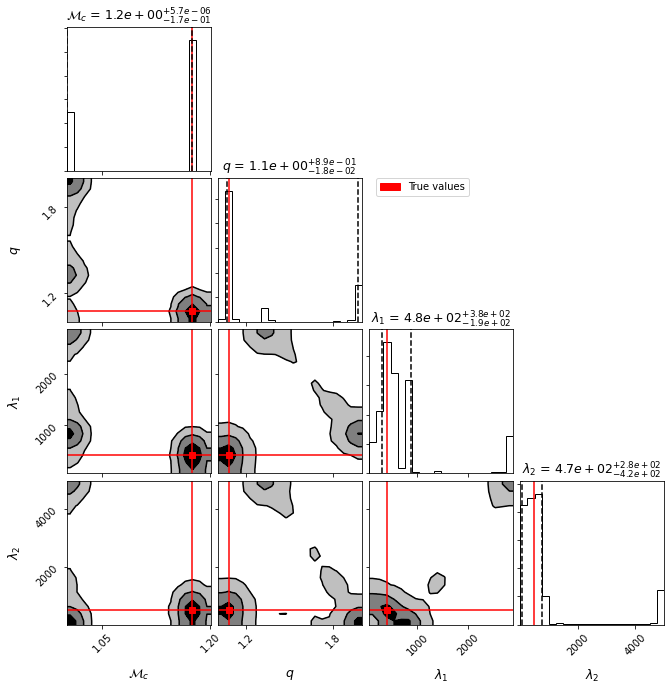

In [28]:
labels = [r'$\mathcal{M}_c$', r'$q$', r'$\lambda_1$', r'$\lambda_2$']
truths=[Mc_inj,q_inj, lambda1_inj, lambda2_inj]

fig = corner.corner(org_samp, bins=20,labels=labels, 
                    truths=truths,
                    truth_color='red', 
                    color='black',**CORNER_KWARGS)

red_patch = mpatches.Patch(color='red', label='True values')
plt.legend(handles=[red_patch],bbox_to_anchor=(-1., 3.1), 
           loc='upper left', borderaxespad=0.)
plt.show()

In [ ]:


org_samp = np.vstack( (flat_samples[:,:,0].flatten(), #mass samples.
                       flat_samples[:,:,1].flatten(), #mass-ratios
                       flat_samples[:,:,2].flatten(),
                       flat_samples[:,:,2].flatten() #spin samples.
                      ) ).T
print("number of samples = ", np.shape(org_samp))
print("median = ", np.median(org_samp,axis=0))

In [ ]:
labels = [r'$\mathcal{M}_c$', r'$q$', r'$\lambda_1$', r'$\lambda_2$']
truths=[Mc_inj,q_inj, lambda1_inj, lambda2_inj]

fig = corner.corner(org_samp, bins=20,labels=labels, 
                    truths=truths,
                    truth_color='red', 
                    color='black',**CORNER_KWARGS)

red_patch = mpatches.Patch(color='red', label='True values')
plt.legend(handles=[red_patch],bbox_to_anchor=(-1., 3.1), 
           loc='upper left', borderaxespad=0.)
plt.show()